In [1]:
import sys
import corner
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PySSC
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
sys.path.append('/pbs/throng/lsst/users/cpayerne/LikelihoodsClusterAbundance/modules/')
import covariance as covar
import utils
import pandas as pd
import abundance as cl_count
from lnlikelihood import lnLikelihood


def save_pickle(dat, filename, **kwargs):
    file = open(filename,'wb')
    pickle.dump(dat, file)
    file.close()

import pyccl as ccl
import edit
import h5py, glob
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]

cosmo = ccl.Cosmology(Omega_c = Omegam_true - 0.048254, Omega_b = 0.048254, 
                              h = 0.6777, sigma8 = sigma8_true, n_s=0.96)

where_cat = '/sps/lsst/users/cpayerne/1000xsimulations/1000_simulations/afumagalli/catalogs/plc_14/*'
cat = glob.glob(where_cat)

for i ,c in enumerate(cat):
    cat_test = pd.read_csv(c ,sep=' ',skiprows=12, names=['M','z','dec','ra'])
    ra, dec, redshift, Mvir = cat_test['ra'], cat_test['dec'], cat_test['z'], cat_test['M']/0.6777
    if i == 20: break

zmin, zmax = 0.2, 1.2
logmmin, logmmax = 14.2, 15.6
nzbins, nmbins = 30, 4

clc = cl_count.ClusterAbundance()
clc.sky_area = (0.25)*4*np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
z_grid = np.linspace(zmin, zmax, 1000)
logm_grid = np.linspace(logmmin, logmmax, 1001)

z_corner = np.linspace(zmin, zmax, nzbins+1)
log10m_corner = np.linspace(logmmin, logmmax, nzbins+1)
Z_bin = [[z_corner[i], z_corner[i+1]] for i in range(len(z_corner)-1)]
LogMass_bin = [[log10m_corner[i], log10m_corner[i+1]] for i in range(len(log10m_corner)-1)]
Nobs, a, b = np.histogram2d(redshift, np.log10(Mvir), bins = [z_corner, log10m_corner])

#choose the halo mass function and mass definition
cosmo = ccl.Cosmology(Omega_c = Omega_c_true + Omega_b_true - 0.048254, Omega_b = 0.048254, 
                          h = 0.6777, sigma8 = sigma8_true, n_s=0.96)
massdef = ccl.halos.massdef.MassDef('vir', 'critical')
hmd = ccl.halos.hmfunc.MassFuncDespali16(mass_def=massdef)
halobias = ccl.halos.hbias.HaloBiasTinker10(mass_def= massdef, mass_def_strict=True)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25) * 4 * np.pi
clc.f_sky = clc.sky_area/(4*np.pi)
#z_grid = np.linspace(0., 2.1, 2500)
#logm_grid = np.linspace(14.1, 15.7, 2501)

clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
clc.compute_halo_bias_grid_MZ(z_grid = z_corner, logm_grid = log10m_corner, halobiais = halobias)
NHalo_bias = clc.Nhalo_bias_MZ(Redshift_bin = Z_bin, Proxy_bin = LogMass_bin, method = 'simps')
Halo_bias = NHalo_bias/Abundance
Covariance = covar.Covariance_matrix()
default_cosmo_params = {'omega_b':cosmo['Omega_b']*cosmo['h']**2, 
                                'omega_cdm':cosmo['Omega_c']*cosmo['h']**2, 
                                'H0':cosmo['h']*100, 
                                'n_s':cosmo['n_s'], 
                                'sigma8': cosmo['sigma8'],
                                'output' : 'mPk'}

/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
z_arr = np.linspace(0.2,1.2,1000)
def window(Z_bin):
    nbins_T   = len(Z_bin)
    windows_T = np.zeros((nbins_T,len(z_arr)))
    for i, z_bin in enumerate(Z_bin):
        Dz = z_bin[1]-z_bin[0]
        z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
        for k, z in enumerate(z_arr):
            if ((z>z_bin[0]) and (z<=z_bin[1])):
                windows_T[i,k] = 1  
    return windows_T

In [3]:
Sij = []
zbin = []
nzbins = [5, 25, 125]
#nzbins = [5, 10, ]
for nbins in nzbins:
    z_corner = np.linspace(zmin, zmax, nbins+1)
    Z_bin = [[z_corner[i], z_corner[i+1]] for i in range(len(z_corner)-1)]
    zbin.append(Z_bin)
    windows = window(Z_bin)
    Sij.append(PySSC.Sij_alt_fullsky(z_arr, windows, order=1, cosmo_params=default_cosmo_params, cosmo_Class=None, convention=0))

In [4]:
sigma2ij = PySSC.sigma2_fullsky(z_arr, cosmo_params=default_cosmo_params, cosmo_Class=None)

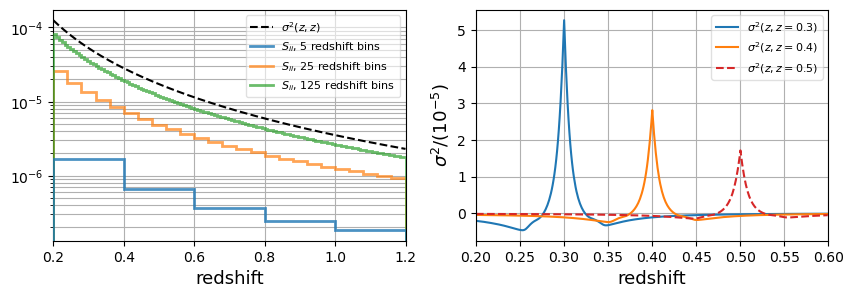

In [21]:
fig = plt.figure(figsize = (10,3))
plt.subplot(121)
plt.plot(z_arr, sigma2ij.diagonal(), '--k', label = r'$\sigma^2(z, z)$')
z_corner = np.linspace(zmin, zmax, nzbins[0]+1)
plt.stairs( Sij[0].diagonal(), z_corner,  alpha=.8, 
           label = r"$S_{ii}$, 5 redshift bins", zorder=100,fill=False, lw=2)
z_corner = np.linspace(zmin, zmax, nzbins[1]+1)
plt.stairs( Sij[1].diagonal(), z_corner,  alpha=.7,
           label = r"$S_{ii}$, 25 redshift bins",zorder=99,fill=False,  lw=2)
z_corner = np.linspace(zmin, zmax, nzbins[2]+1)
plt.stairs( Sij[2].diagonal(), z_corner, alpha=.7,
           label = r"$S_{ii}$, 125 redshift bins",zorder=99,fill=False,lw=2 )
plt.yscale('log')
plt.xlim(0.2, 1.2)
plt.legend(frameon=True, fontsize=8, framealpha=.6, facecolor='white', loc= 'upper right')
plt.xlabel('redshift', fontsize=13)
plt.grid(True, which='both')
plt.subplot(122)
mask = z_arr < 0.6
plt.plot(z_arr[mask], sigma2ij[:,100][mask]*10**5, 'C0', label = f'$\sigma^2(z, z = {z_arr[100]:.1f})$')
plt.plot(z_arr[mask], sigma2ij[:,200][mask]*10**5, 'C1', label = f'$\sigma^2(z, z = {z_arr[200]:.1f})$')
plt.plot(z_arr[mask], sigma2ij[:,300][mask]*10**5, '--C3', label = f'$\sigma^2(z, z = {z_arr[300]:.1f})$')
plt.xlim(0.2, 0.6)
plt.ylabel(r'$\sigma^2/(10^{-5})$', fontsize=13)
plt.legend(frameon=True, fontsize=8, framealpha=.6, facecolor='white', loc= 'upper right')
plt.xlabel('redshift', fontsize=13)
plt.grid(True)
plt.savefig('sigmaSSC.pdf', bbox_inches='tight', dpi=300)